# Data download and exploratory analysis

Currently precipitation radar nowcasting is mainly done by optical flow or radial velocity estimates. If we use neural nets we can maybe capture the behavior of rain clouds better (e.g. a single summer evening cumulonimbus versus a heat front), and the topographic influences (e.g. fohn effect), without explicitly specifying rules or terrain.

## Relevant papers

It's already being done here: http://arxiv.org/pdf/1506.04214.pdf

## Data

The KNMI has an [open data program](http://data.knmi.nl) now. I identified three interesting datasets:

- [2008-] [5-min radar reflectivity composites](http://data.knmi.nl/datasets/radar_tar_refl_composites/1.0), this is what we're trying to establish the behavior of, and what should be our internal state.
- [2008-] [Forecasted 5-min radar reflectivity composites](http://data.knmi.nl/datasets/radar_forecast/1.0), this is our baseline, where they extrapolate the radar images based on a velocity estimate. Only the data of last day is online, which is a pity. Might contact them to get my hands on more data.
- [2008-] [5-min gauge-adjusted precipitation accumulations (1 km, extended mask)](http://data.knmi.nl/datasets/rad_nl25_rac_mfbs_em_5min/2.0), this can serve as the ground truth. Would be amazing if we can train with radar reflectivity as input and this as output, then the errors in the reflectivity composites might be diminished.
- [2014-] [Radar echo top height composites](http://data.knmi.nl/datasets/radar_tar_echotopheight_5min/1.0), I'm not keen on training on the full radar reflectivity volumes, but this might just be a nice derivative that does give extra information that might add to the model's predictive power.

Most of this data is available via FTP. The format, projection and extent is described at http://adaguc.knmi.nl/contents/datasets/productdescriptions/W_ADAGUC_Product_description_RADNL_OPER_R___25PCPRR_L3.html.

## Dependencies

`conda install h5py tqdm matplotlib pyproj`

`conda install -c conda-forge cartopy`

Use SIMD-accelerated pillow for faster resizing:
`CC="cc -mavx2" pip install -U --force-reinstall pillow-simd`

In [1]:
# All imports
import os, io, re, glob, tarfile
import concurrent.futures
from pprint import pprint

# Third parties
import h5py
import numpy as np
from IPython.display import Image
from ftplib import FTP
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

# Own code
import utils

# Constants
folder = utils.RADAR_REFL_COMP_DIR

%matplotlib inline
%load_ext autoreload

### File discovery

The radar reflectivity composites are organized in *.tar* files, one per day. Let's retrieve all their filenames. (This can take a while for something like 10\*365 filenames.)

In [104]:
## Ok, now on to the real stuff: radar reflectivity composites
refl_comp_ftp_urls = []

with FTP('data.knmi.nl', timeout=10) as ftp:
    print(ftp.login())
    yearfolders = ftp.nlst('/download/radar_tar_refl_composites/1.0/0001/')
    for yearfolder in yearfolders:
        for monthfolder in ftp.nlst(yearfolder):
            for dayfolder in ftp.nlst(monthfolder):
                # Should contain just one file
                for day_file in ftp.nlst(dayfolder):
                    refl_comp_ftp_urls.append(day_file)
                    # Use carriage return to overwrite
                    print("Retrieve filename # {}".format(len(refl_comp_ftp_urls)), end='\r')

print("Finished")

# Save to file for later retrieval
with open('refl_comp_ftp_urls.txt', 'w') as f:
    f.write('\n'.join(refl_comp_ftp_urls))

230 login accepted
Finished filename # 3607


Run the cell below to restore urls from file.

In [75]:
# Run this to restore from file
with open('refl_comp_ftp_urls.txt', 'r') as f:
    # Clean up \n's
    refl_comp_ftp_urls = [l.strip() for l in f.readlines()]
print("Loaded {} filenames".format(len(refl_comp_ftp_urls)))

Loaded 3602 filenames


### Downloading files

Now we download all files. You probably want to download a smaller subset at first because this can take hours (it's >75GB and their ftp server is not so fast).

In [105]:
with FTP('data.knmi.nl', timeout=10) as ftp:
    print(ftp.login())
    for ftp_url in tqdm_notebook(refl_comp_ftp_urls[-10:], desc="Downloading files", unit="file"):
        utils.download_cache_ftp(utils.RADAR_REFL_COMP_DIR, ftp, ftp_url, verbose=False)

230 login accepted


HBox(children=(IntProgress(value=0, description='Downloading files', max=10), HTML(value='')))

Next step is to untar all the files. I'd like to do that in streaming fashion but the h5py library doesn't support that in an easy way.

So now we untar to disk, taking care to check if the files exist and then deleting the original file to save space. The code is slightly more verbose because of the concurrency.

In [106]:
tar_files = sorted(glob.glob(os.path.join(folder, '*.tar')))

print("Found {} tar files in {}".format(len(tar_files), folder))

utils.untar_concurrent(tar_files)

Found 10 tar files in /home/ubuntu/nowcasting-convrnn/data/radar_refl_comp
Submitted all tasks


HBox(children=(IntProgress(value=1, bar_style='info', description='Extracting', max=1), HTML(value='')))

In [2]:
## Construct dataset obj compliant with torch abstractions

class ReflCompTarDataset():
    def __init__(self, folder):
        "Search folder for hdf5 files and add them to dataset"
        # Sort by filename, which reflects date
        self.h5files = sorted(glob.glob(os.path.join(folder, '*.h5')))
    
    def show_structure(self, idx):
        "Returns list of lines, showing groups, datasets and attributes"
        h5file = self.__getitem__(idx)
        return utils.explain_hdf5_file(h5file)
    
    def __getitem__(self, idx):
        return h5py.File(self.h5files[idx])
    
    def crunch(n_workers=8):
        "Crunch through the entire dataset, gathering stats"
        pass

ds = ReflCompTarDataset(folder)
print("File 20 contains:")
print('\n'.join(ds.show_structure(-1)))

File 20 contains:
geographic
	<HDF5 group "/geographic" (1 members)>
		geo_par_pixel: b'X,Y'
		geo_dim_pixel: b'KM,KM'
		geo_pixel_def: b'LU'
		geo_number_columns: [700]
		geo_number_rows: [765]
		geo_pixel_size_x: [ 1.00000346]
		geo_pixel_size_y: [-1.00000477]
		geo_column_offset: [ 0.]
		geo_row_offset: [ 3649.98193359]
		geo_product_corners: [  0.          49.36206436   0.          55.97360229  10.85645294
  55.38897324   9.00930023  48.89530182]

geographic/map_projection
	<HDF5 group "/geographic/map_projection" (0 members)>
		projection_indication: b'Y'
		projection_name: b'STEREOGRAPHIC'
		projection_proj4_params: b'+proj=stere +lat_0=90 +lon_0=0 +lat_ts=60 +a=6378.14 +b=6356.75 +x_0=0 y_0=0'

image1
	<HDF5 group "/image1" (3 members)>
		image_product_name: b'RAD_NL25_PCP_H1.5_NA'
		image_geo_parameter: b'REFLECTIVITY_[DBZ]'
		image_size: [535500]
		image_bytes_per_pixel: [1]

image1/calibration
	<HDF5 group "/image1/calibration" (0 members)>
		calibration_flag: b'Y'
		calibrat

In [ ]:
import multiprocessing

def map_reduce(indexes, map_func, reduce_func, n_workers=8, chunk_size=1000, stop_signal_queue=None):
    with concurrent.futures.ProcessPoolExecutor(max_workers=n_workers) as tpe:
        index_groups = np.array(indexes).reshape((-1,chunk_size))
        futs = [tpe.submit(map_func, indx, stop_signal_queue) for indx in index_groups]
        results = []
        with tqdm_notebook(total=len(futs)*chunk_size) as pbar:
            for fut in concurrent.futures.as_completed(futs):
                pbar.update(chunk_size)
                results.append(fut.result())
#                 if stop_signal_queue and not stop_signal_queue.empty():
#                     break
#     if stop_signal_queue and not stop_signal_queue.empty():
#         return
#     else:
    return reduce_func(results, len(indexes))

def sum_array(indexes, stop_signal_queue):
    if stop_signal_queue and not stop_signal_queue.empty():
        return
    firsttime = True
    accumulator = None
    # Prevent too many open file errors
    for indx in indexes:
        with h5py.File(ds.h5files[indx]) as f:
            try:
                img = np.array(f['image1']['image_data']).astype(np.float32)
            except KeyError:
                # Ignore when it doesn't have 'image1'
                # TODO: Signal
                return accumulator
            # Set out of range to 0
            img[img==255] = 0
            # Cutoff at 60
            img[img<60] = 0
            if firsttime:
                firsttime = False
                accumulator = img
            else:
                accumulator += img
    return accumulator

def reduce_func(iterator, l):
    # Mean
    return np.sum(iterator, axis=0) / l

# TODO: Make interrupt handling work, then put in utils

# Handling of ctrl-c doesn't work yet, not sure where the problem lies
# Approach seems to be ok
try:
    manager = multiprocessing.Manager()
    stop_signal = manager.Queue()
    accumulator2 = map_reduce(range(400000), sum_array, reduce_func,
                             n_workers=8, chunk_size=10000,
                             stop_signal_queue=stop_signal)
except KeyboardInterrupt:
    print("Stopping...")
    stop_signal.put(1)

print(accumulator2)

HBox(children=(IntProgress(value=0, max=400000), HTML(value='')))

NameError: name 'accumulator2' is not defined

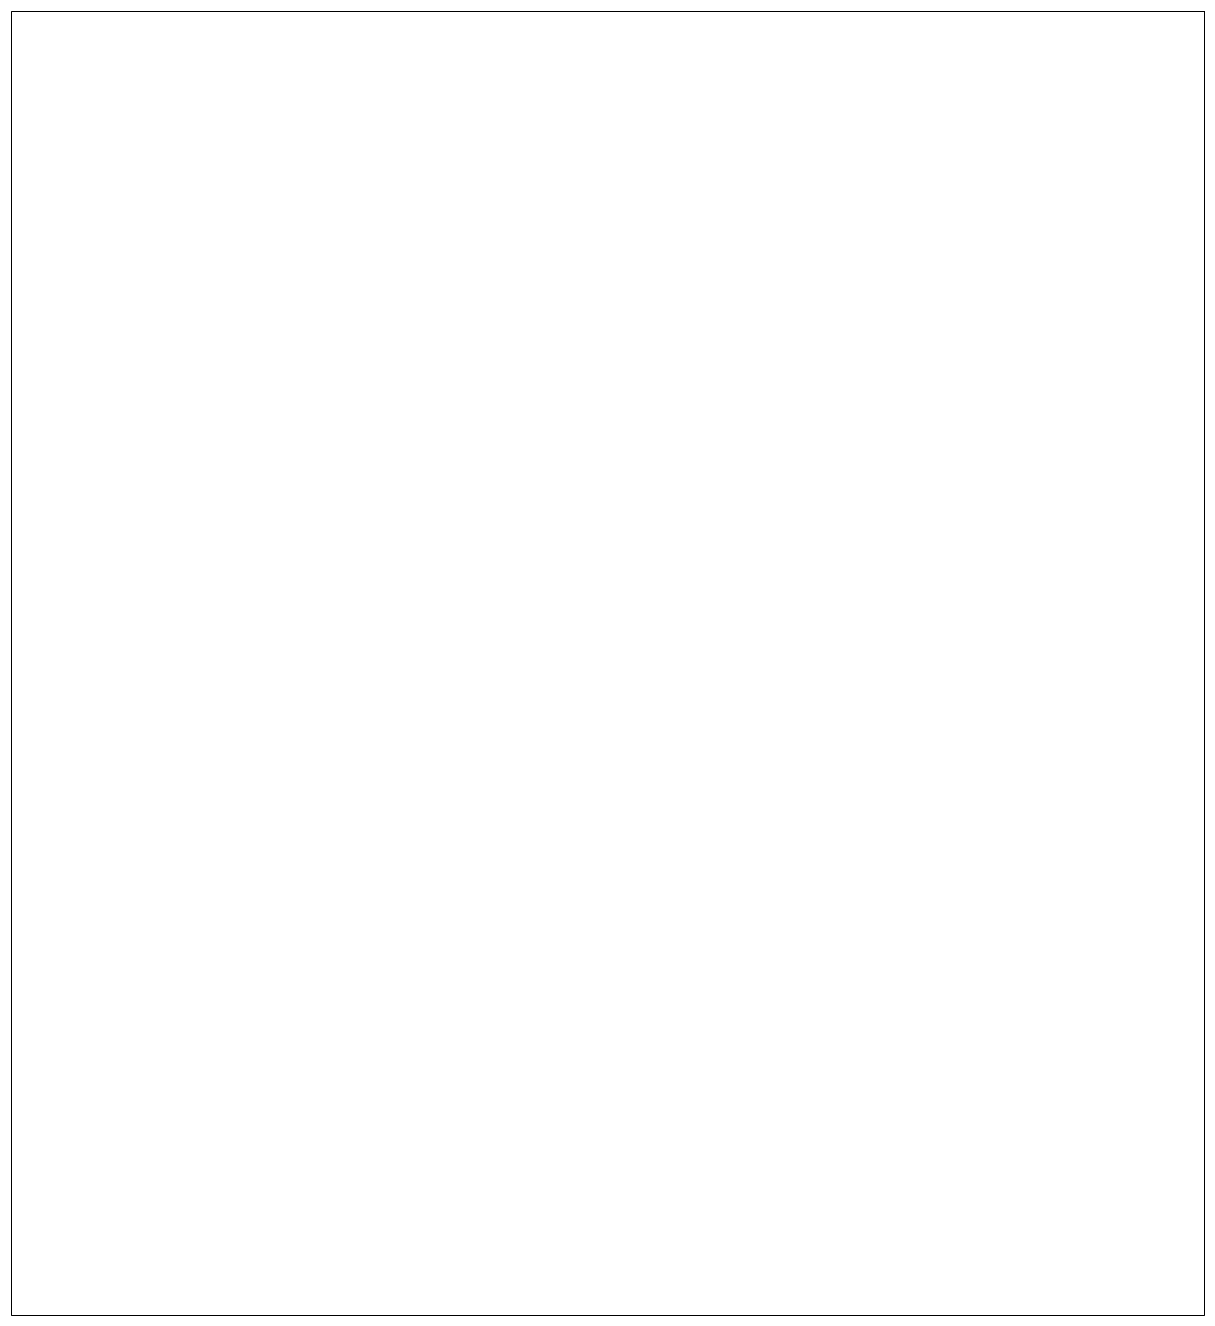

In [8]:
# TODO: Clean up rendering, use properties in h5 file,
#       then put in plotting module

from matplotlib import animation, rc
from IPython.display import HTML

#!conda install -c conda-forge cartopy
import cartopy.crs as ccrs
import cartopy.feature

stere_nl = ccrs.Stereographic(central_latitude=90, true_scale_latitude=60)
stere_nl.proj4_params

'+proj=stere +lat_0=90 +lon_0=0 +lat_ts=60 +a=6378.14 +b=6356.75 +x_0=0 y_0=0'
# 0.0, 49.36206, 0.0, 55.973602, 10.856429, 55.388973, 9.00928, 48.8953
bbox = np.array([[  0.      ,  49.36206 ],
                 [  0.      ,  55.973602],
                 [ 10.856429,  55.388973],
                 [  9.00928 ,  48.8953  ]])

bbox_stere = stere_nl.transform_points(ccrs.PlateCarree(), bbox.T[0], bbox.T[1])[:,:2]

proj_pc = ccrs.PlateCarree()

fig = plt.figure(figsize=(24,24))

ax = plt.axes(projection=stere_nl)

ext = (bbox[:,0].min(), bbox[:,0].max(), bbox[:,1].min(), bbox[:,1].max())

ext_stere = (0, 700000, -4415000, -3650000)

ax.set_extent(ext_stere, crs=stere_nl)

# We need one extra, not sure why
lons = np.linspace(ext_stere[0], ext_stere[1], 701)
lats = np.linspace(ext_stere[2], ext_stere[3], 766)

cmesh = ax.pcolormesh(lons, lats, accumulator2[::-1,:])#np.array(ds[0]['image1']['image_data']))

# def animate(i):
#     arr = np.array(ds[-400+i*12]['image1']['image_data'])
# #     cmesh = ax.pcolormesh(lons, lats, arr)
#     cmesh.set_array(arr.ravel())
#     return cmesh.findobj()

# Add high-res coastline
ax.coastlines('10m', color='white')
# Add high-res border
ax.add_feature(cartopy.feature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', '10m'),
               edgecolor='white', facecolor='none')
ax.gridlines(crs=stere_nl)
# plt.show()



# anim = animation.FuncAnimation(fig, animate,
#                                frames=300, interval=200, blit=True)

# Nice slice would be radar[250:550,200:500]

# HTML(anim.to_html5_video())

In [38]:
with FTP('data.knmi.nl', timeout=10) as ftp:
    print(ftp.login())
    # Only data of last 24 hours is stored here
    most_recent_year = sorted(ftp.nlst('/download/radar_forecast/1.0/noversion/'))[-1]
    most_recent_month = sorted(ftp.nlst(most_recent_year))[-1]
    # These 24 hours are usually divided over 2 days except when the clock strikes midnight
    days = sorted(ftp.nlst(most_recent_month))
    predictions = []
    for day in days:
        # Use extend cause ftp.nlst returns array of arrays
        predictions.extend(ftp.nlst(day))
    # Split limited number of times to show the year/month/day folders
    print("Found {} predictions from {} to {}".format(
        len(predictions),
        predictions[0].split('/',5)[-1],
        predictions[1].split('/',5)[-1]))

    # Download last day of predictions
    for ftp_url in tqdm_notebook(predictions, desc="Downloading files", unit="file"):
        utils.download_cache_ftp(utils.RADAR_FORECAST_REFL_COMP_DIR, ftp, ftp_url, verbose=False)

230 login accepted
Found 295 predictions from 2017/11/27/RAD_NL25_PCP_FM_1745.h5 to 2017/11/27/RAD_NL25_PCP_FM_1750.h5
230 login accepted


A Jupyter Widget

In [7]:
predh5s = sorted(glob.glob(os.path.join(utils.RADAR_FORECAST_REFL_COMP_DIR, '*.h5')))
hfs = []
for p in predh5s:
    hf = h5py.File(p)
    hfs.append(hf)

OSError: Unable to create file (unable to open file: name = '/home/ubuntu/nowcasting-convrnn/data/radar_forecast_refl_comp/RAD_NL25_PCP_FM_0000.h5', errno = 17, error message = 'File exists', flags = 15, o_flags = c2)

In [52]:
img_data = []

def get_img_data(name, obj):
    m = re.match('^image(\d+)/image_data', name)
    if m:
        i = int(m.groups()[0])
        img_data.append([i, np.array(obj)])

hfs[0].visititems(get_img_data)

# They might have been visited in arbitrary order
img_data = [d for i,d in sorted(img_data, key=lambda o: o[0])]

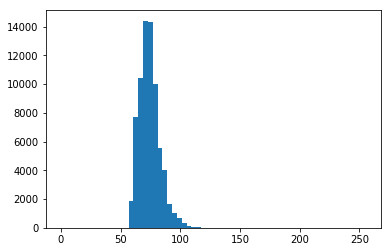

In [100]:
# 60 cutoff
plt.hist(img_data[0][img_data[0]>0].flatten(), bins=255//4, range=(0,255));

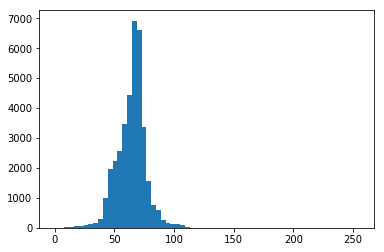

In [101]:
a = np.array(ds[0]['image1/image_data'])
plt.hist(a[(a>0)&(a<255)].flatten(), bins=255//4, range=(0,255));

In [102]:
img_data[0][img_data[0]>0].flatten().min()

60

In [103]:
pv = 60
.5 * pv + -32

-2.0

In [63]:
print(''.join(utils.explain_hdf5_file(hfs[0])))

geographic
	<HDF5 group "/geographic" (1 members)>
		geo_par_pixel: b'X,Y'
		geo_dim_pixel: b'KM,KM'
		geo_pixel_def: b'LU'
		geo_number_columns: [700]
		geo_number_rows: [765]
		geo_pixel_size_x: [ 1.00000346]
		geo_pixel_size_y: [-1.00000477]
		geo_column_offset: [ 0.]
		geo_row_offset: [ 3649.98193359]
		geo_product_corners: [  0.          49.36206436   0.          55.97360229  10.85645294
  55.38897324   9.00930023  48.89530182]
geographic/map_projection
	<HDF5 group "/geographic/map_projection" (0 members)>
		projection_indication: b'Y'
		projection_name: b'STEREOGRAPHIC'
		projection_proj4_params: b'+proj=stere +lat_0=90 +lon_0=0 +lat_ts=60 +a=6378.14 +b=6356.75 +x_0=0 y_0=0'
image1
	<HDF5 group "/image1" (3 members)>
		image_geo_parameter: b'REFLECTIVITY_[DBZ]'
		image_size: [535500]
		image_bytes_per_pixel: [1]
		image_cloud_mask_applied: b'1'
		image_product_name: [b'RAD_NL25_PCP_H1.5_FM']
		image_datetime_valid: [b'28-NOV-2017;00:00:00.000']
image1/calibration
	<HDF5 group "/

In [ ]:
from matplotlib import animation, rc
from IPython.display import HTML

#!conda install -c conda-forge cartopy
import cartopy.crs as ccrs
import cartopy.feature

stere_nl = ccrs.Stereographic(central_latitude=90, true_scale_latitude=60)
stere_nl.proj4_params

# '+proj=stere +lat_0=90 +lon_0=0 +lat_ts=60 +a=6378.14 +b=6356.75 +x_0=0 y_0=0'
# 0.0, 49.36206, 0.0, 55.973602, 10.856429, 55.388973, 9.00928, 48.8953
bbox = np.array([[  0.      ,  49.36206 ],
                 [  0.      ,  55.973602],
                 [ 10.856429,  55.388973],
                 [  9.00928 ,  48.8953  ]])

bbox_stere = stere_nl.transform_points(ccrs.PlateCarree(), bbox.T[0], bbox.T[1])[:,:2]

proj_pc = ccrs.PlateCarree()

fig = plt.figure(figsize=(24,24))

ax = plt.axes(projection=stere_nl)

ext = (bbox[:,0].min(), bbox[:,0].max(), bbox[:,1].min(), bbox[:,1].max())

ext_stere = (0, 700000, -4415000, -3650000)

ax.set_extent(ext_stere, crs=stere_nl)

# We need one extra, not sure why
lons = np.linspace(ext_stere[0], ext_stere[1], 701)
lats = np.linspace(ext_stere[2], ext_stere[3], 766)

cmesh = ax.pcolormesh(lons, lats, img_data[0])

def animate(i):
#     cmesh = ax.pcolormesh(lons, lats, arr)
    cmesh.set_array(img_data[i].ravel())
    return cmesh.findobj()

# Add high-res coastline
ax.coastlines('10m', color='white')
# Add high-res border
ax.add_feature(cartopy.feature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', '10m'),
               edgecolor='white', facecolor='none')
ax.gridlines(crs=stere_nl)
# plt.show()



anim = animation.FuncAnimation(fig, animate,
                               frames=len(img_data), interval=200, blit=True)

# Nice slice would be radar[250:550,200:500]

HTML(anim.to_html5_video())

The commonly used precipitation metrics are:
 - Rainfall-MSE *average squared error between the predicted rainfall and the ground truth (needs conversion of pixel values -> radar intensity [dB] -> rainfall (Z-R relationship)*

For the following metrics the prediction and ground truth is converted to a 0/1 matrix using a treshold of $0.5mm/h$.
 - Critical Success Index (CSI) $\frac{hits}{hits+misses+falsealarms}$
 - False Alarm Rate (FAR) $\frac{falsealarms}{hits+falsealarms}$
 - Probability Of Detection (POD) $\frac{hits}{hits+misses}$


In [4]:
def metrics(t, p):
    """
    Calculates the Critical Success Index of tresholded 0/1 matrix
    :param t: np.array ground truth
    :param p: prediction
    :returns: Tuple of (CSI, FAR, POD, correlation) normalized scores
    """
    hits = ((t==1)&(p==1)).sum()
    misses = ((t==1)&(p==0)).sum()
    falsealarms = ((t==0)&(p==1))
    
    # Normalize scores by dividing by total # of pixels    
    csi = hits / (hits + misses + falsealarms) / t.size()
    far = falsealarms / (hits + falsealarms) / t.size()
    pod = hits / (hits + misses) / t.size()
    
    # Correlation
    cor = (t*p).sum() / (np.sqrt((p**2).sum() * (t**2).sum()) + 10e-9)
    
    return csi, far, pod, cor

In [5]:
predh5s

NameError: name 'predh5s' is not defined